## Task 2: Streaming data visualization

<IPython.core.display.Javascript object>


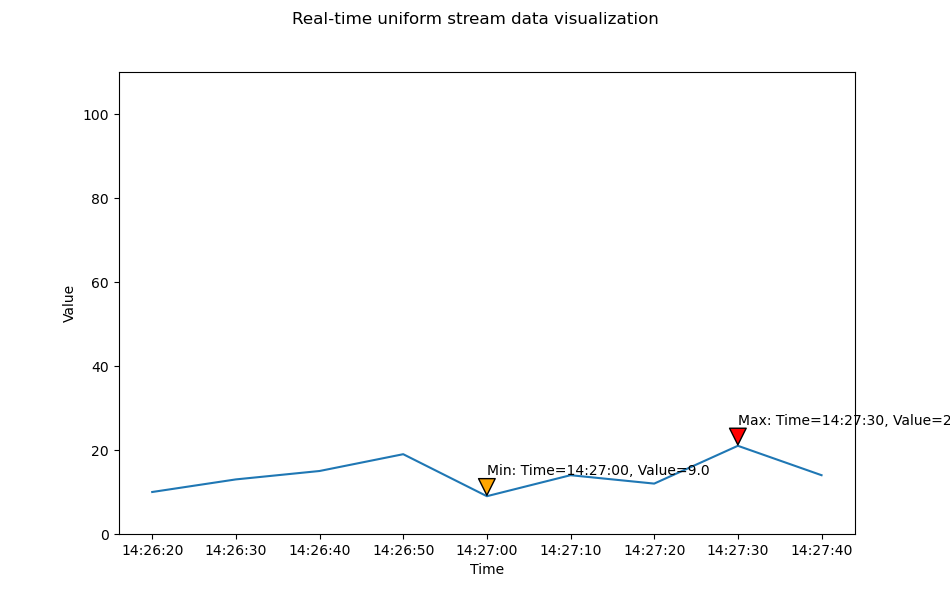

KeyboardInterrupt: 

In [1]:
# import statements
from time import sleep
from kafka3 import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
import json

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'partB1'
hostip = "10.192.96.162" 

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
#                                    auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=[f'{"10.192.96.162"}:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)
    
def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.set_ylim(0,110) 
        ax.set_yticks([0,20,40,60,80,100])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        # print('Waiting for messages')
        for message in consumer:
            key = message.key.decode("utf-8")
            if key == "producer1":
                decode = str(message.value.decode('utf-8'))
                data = json.loads(decode)
                x.append(dt.datetime.now().strftime("%X")) 
                y.append(data['air_temperature_celcius'])
                # print(y)
                # we start plotting only when we have 10 data points

                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Time')
                ax.set_ylabel('Value')
                ax.set_ylim(0,110) 
                ax.set_yticks([0,20,40,60,80,100])
                annotate_max(x,y)
                annotate_min(x,y)
                fig.canvas.draw()
                if len(y) > 10:
                    x.pop(0) # removing the item in the first position
                    y.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)
    
    

## Static Task Visualisation Part A

In [2]:
import sys, getopt, pprint
from pymongo import MongoClient
from pprint import pprint
from datetime import datetime

mongo_client=MongoClient(host = f'{"10.192.96.162"}', port = 27017)
db=mongo_client.assignment2

In [10]:
collection = db.hotspots
documents = collection.find()
results = collection.aggregate([
    {"$project":{"_id":0, "hotspot": 1}}
])
# print(results)
#24hour format hence we create 24 numbers of integer to store the number of fire records 
aDay = [0 for i in range(24)]
print(aDay)
for document in results:
    if len(document) != 0:
        time_str = document['hotspot'][0]['date_time']
        time_obj = datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S')
        hour = time_obj.strftime('%H')
        aDay[int(hour)] += 1
print(aDay)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 102, 29, 0, 0, 0, 0, 0, 0, 0, 0, 0]


<IPython.core.display.Javascript object>


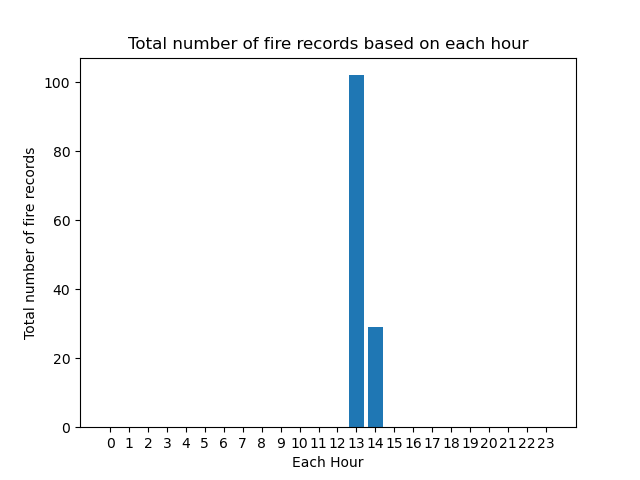

In [11]:
import matplotlib.pyplot as plt
plt.close('all')
fig, ax = plt.subplots()

Time = list(range(24)) 
# Plot the data
ax.bar(Time, aDay)

# Set the labels and title
ax.set_xlabel("Each Hour")
ax.set_ylabel("Total number of fire records")
ax.set_title("Total number of fire records based on each hour")

# Ensure the labels are displayed correctly
ax.set_xticks(Time)
ax.set_xticklabels(Time)

# Show the plot
plt.show()

## Part B

In [12]:
#!pip install folium

In [13]:
from pymongo import MongoClient
import folium
host_ip = "10.192.96.162"

mongo_client=MongoClient(host = f'{"10.192.96.162"}', port = 27017)
db=mongo_client.assignment2
collection = db.hotspots
# Preparing the data for plotting
unoccupiedList = []

# Initialize the map centered around a specific location
fomap = folium.Map(location=[-37.812015244225677, 144.951471202974], zoom_start=6)

# Looping through all the data
for row in collection.find():
    if row['cause_of_fire'] == 'natural':
        marker_color = 'blue'
    else:
        marker_color = 'red'
    fomap = folium.Map(location=[-37.812015244225677, 144.951471202974], zoom_start=6)
    folium.Marker(location=[row['latitude'], row['longitude']],popup=f"lat={row['latitude']}, lon={row['longitude']}", max_width=300,icon=folium.Icon(color=marker_color)).add_to(fomap)
fomap    